In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os, sys
from google.colab import drive
from datetime import date, datetime
import itertools
from scipy.stats import chi2_contingency, chi2
%matplotlib inline

### Importing the data set

In [43]:
drive.mount('/content/drive')
%cd /content/drive/My\ Drive
df=pd.read_csv('dataset_csv.csv', low_memory=False)
df=df.iloc[:,1:]
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


,Invoice,Sales Product,Stock Code,Alpha Code,Alpha Code.1,Quantity,Invoice Date,Price per Unit,Customer,Customer ID,Industry,Country,Unnamed: 12,Distributor,Operating Division,Unnamed: 15,Final Price,Invoice Month,Day of week,Invoice Datetime
0,553503,NEOPOLEN P 9230 K BS,90214Y,NEOPOLEN P EX BSW,DLG,1,2011-05-17,0.83,SCHATTDECOR DO BRASI,14606,#,Romania,RO,Distributor no,PERFORMANCE MATERIAL,PM,0.83,May,Tuesday,2011-05-17 13:20:00
1,536591,NEOPOLEN P 9255 BSW,90214V,NEOPOLEN P EX BSW,DLG,1,2010-12-01,0.83,SCHATTDECOR DO BRASI,14606,#,Romania,RO,Distributor no,PERFORMANCE MATERIAL,PM,0.83,December,Wednesday,2010-12-01 16:57:00
2,556202,NEOPOLEN P 9255 BSW,90214V,NEOPOLEN P EX BSW,DLG,1,2011-06-09,0.83,SCHATTDECOR DO BRASI,14606,#,Romania,RO,Distributor no,PERFORMANCE MATERIAL,PM,0.83,June,Thursday,2011-06-09 13:08:00
3,536591,NEOPOLEN P 9225 K BS,90214S,NEOPOLEN P EX BSW,DLG,1,2010-12-01,0.83,SCHATTDECOR DO BRASI,14606,#,Romania,RO,Distributor no,PERFORMANCE MATERIAL,PM,0.83,December,Wednesday,2010-12-01 16:57:00
4,537765,NEOPOLEN P 9225 K BS,90214S,NEOPOLEN P EX BSW,DLG,2,2010-12-08,0.83,SCHATTDECOR DO BRASI,14606,#,Romania,RO,Distributor no,PERFORMANCE MATERIAL,PM,1.66,December,Wednesday,2010-12-08 12:08:00


### Data quality analysis 
•	Missing values
•	Extremes
•	Distribution of each variable


In [55]:
df.dtypes

Invoice                string
Sales Product          object
Stock Code             object
Alpha Code             object
Alpha Code.1           object
Quantity                int64
Invoice Date           object
Price per Unit        float64
Customer               object
Customer ID            string
Industry               object
Country                object
Unnamed: 12            object
Distributor            object
Operating Division     object
Unnamed: 15            object
Final Price           float64
Invoice Month          string
Day of week            string
dtype: object

In [57]:
df['Invoice']=df['Invoice'].astype('string')
df['Customer ID']=df['Customer ID'].astype('string')
df['Invoice Month']=df['Invoice Month'].astype('string')
df['Day of week']=df['Day of week'].astype('string')
month_number=[]
for m in df['Invoice Month'].values:
  month_number.append(datetime.strptime(m, "%B").month)
df['Invoice Month']=month_number
df['Invoice Date']=pd.to_datetime(df['Invoice Date'])
df['Month_Year'] = df['Invoice Date'].dt.to_period('M')

In [58]:
#Duplicates
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(203891, 20)
(201626, 20)


In [59]:
#Missing values
df.isnull().sum().sum()

0

In [60]:
#Distribution of each continuous variable
j=df.describe()
for i in j.columns:
  j[i]=j[i].astype(int)
j

,Quantity,Price per Unit,Final Price,Invoice Month
count,201626,201626,201626,201626
mean,12,2,23,5
std,32,2,78,3
min,1,0,0,1
25%,2,1,5,3
50%,6,1,12,5
75%,12,3,19,7
max,1056,16,5970,12


In [61]:
numerical=df.select_dtypes(include=['number'])
categorical=df.select_dtypes(include=['object'])

In [64]:
var_range=[]
IQR=[]
var_coef=[]
std=[]
var=[]
mean=[]

for i in range(numerical.shape[1]):
    var_range.append(numerical.iloc[:,i].max()-numerical.iloc[:,i].min())

for i in range(numerical.shape[1]):
    IQR.append(numerical.iloc[:,i].quantile(0.75)-numerical.iloc[:,i].quantile(0.25))
    
for i in range(numerical.shape[1]):
    std.append(numerical.iloc[:,i].std())

for i in range(numerical.shape[1]):
    var.append(numerical.iloc[:,i].var())
    
for i in range(numerical.shape[1]):
    mean.append(numerical.iloc[:,i].mean())

for i in range(numerical.shape[1]):
    var_coef.append(round(numerical.iloc[:,i].std()/numerical.iloc[:,i].mean()*100,3))

data={
    'Varianton range' : var_range,
     'IQR' : IQR,
    'Standard deviation' : std,
    'Variance' : var,
    'Mean' : mean,
    'Variation coefficient' : var_coef
}
index=list(numerical.columns)

Statistical_dispersion=pd.DataFrame(data=data, index=index)
Statistical_dispersion

,Varianton range,IQR,Standard deviation,Variance,Mean,Variation coefficient
Quantity,1055.00,10.00,32.989617,1088.314797,12.694117,259.881
Price per Unit,16.91,2.50,2.832023,8.020352,2.911526,97.269
Final Price,5969.90,14.76,78.194771,6114.422150,23.820021,328.273
Invoice Month,11.00,4.00,3.192248,10.190446,5.284244,60.411


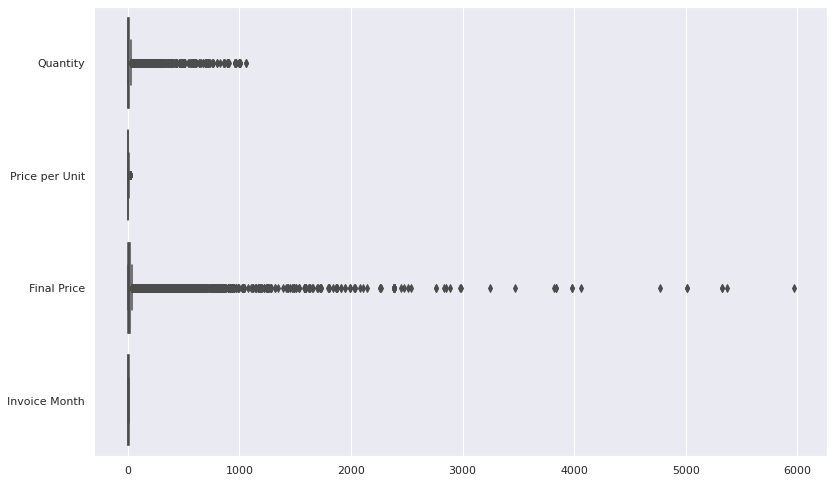

In [65]:
#Outliers
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data=df, orient="h")

In [66]:
cat=categorical.drop_duplicates()

In [ ]:
# Frequency
for i in range(cat.shape[1]):
    print(cat.iloc[:,i].value_counts(normalize=True))
    print()

Text(0.5, 0, 'ratio of a category')

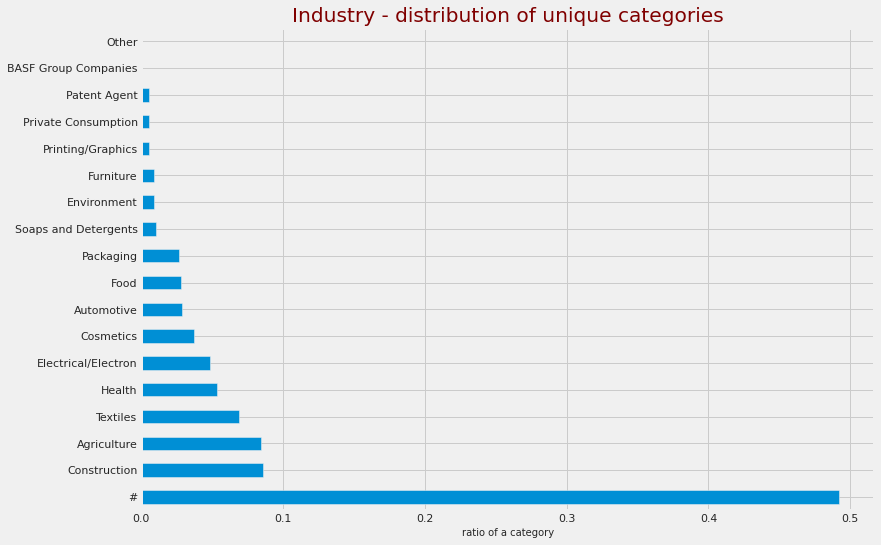

In [67]:
plt.style.use('fivethirtyeight')
cat['Industry'].value_counts(normalize=True).plot(kind='barh')
plt.title('Industry - distribution of unique categories', color='maroon')
plt.xlabel('ratio of a category', fontsize=10) 

Text(0.5, 0, 'ratio of a category')

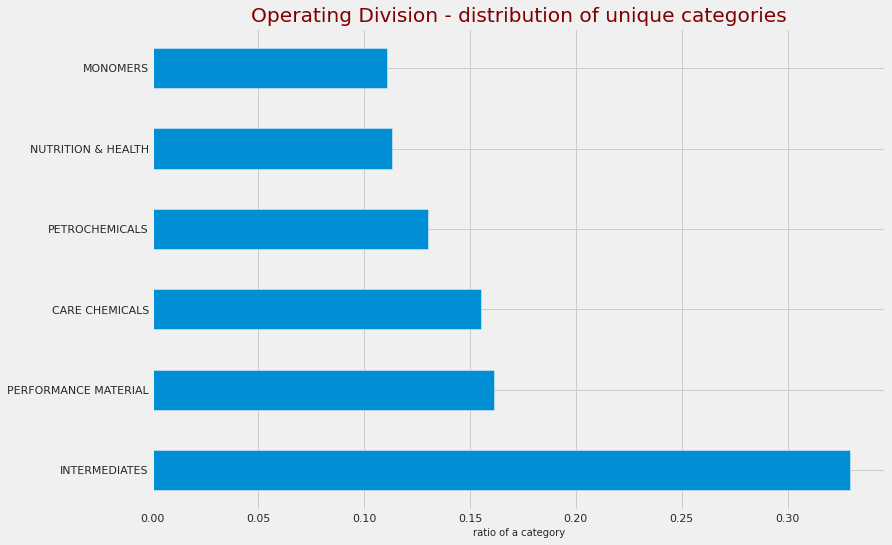

In [68]:
cat['Operating Division'].value_counts(normalize=True).plot(kind='barh')
plt.title('Operating Division - distribution of unique categories', color='maroon')
plt.xlabel('ratio of a category', fontsize=10) 

Text(0.5, 0, 'ratio of a category')

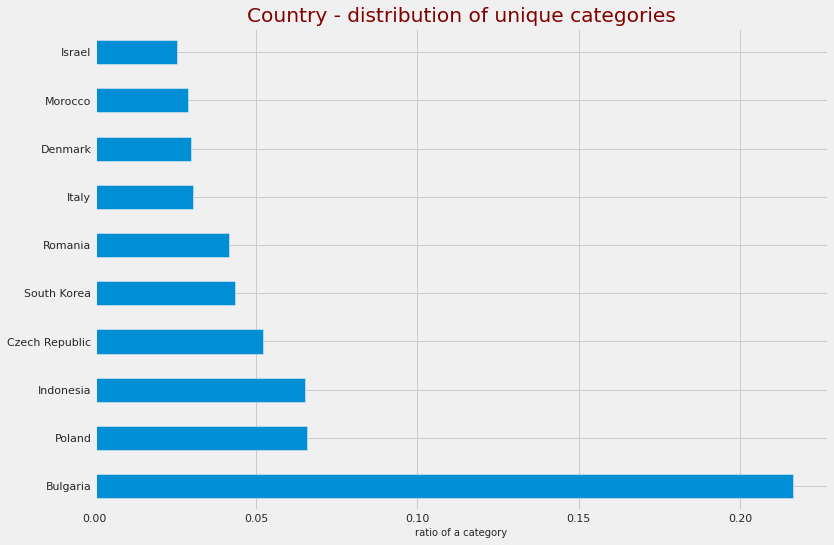

In [69]:
cat['Country'].value_counts(normalize=True)[:10].plot(kind='barh')
plt.title('Country')
plt.title('Country - distribution of unique categories', color='maroon')
plt.xlabel('ratio of a category', fontsize=10) 

Text(0.5, 0, 'ratio of a category')

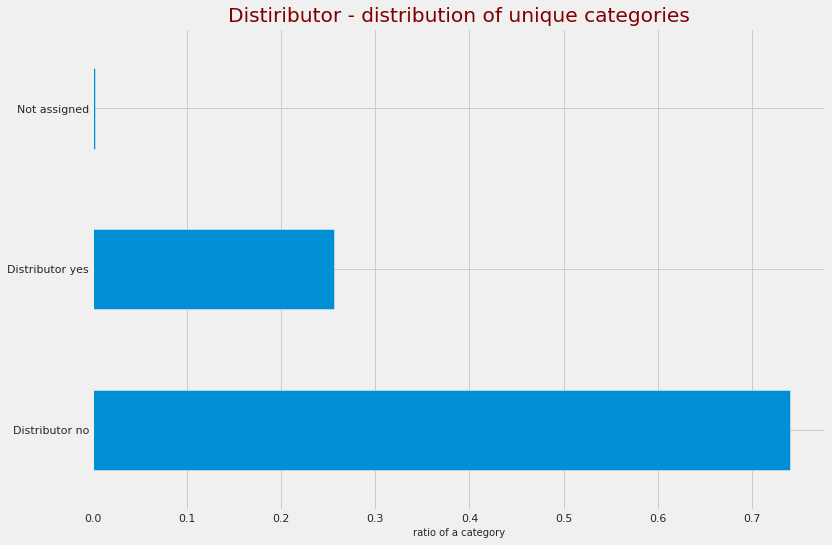

In [70]:
cat['Distributor'].value_counts(normalize=True).plot(kind='barh')
plt.title('Distributor')
plt.title('Distiributor - distribution of unique categories', color='maroon')
plt.xlabel('ratio of a category', fontsize=10) 

In [71]:
# Correlation
numerical.corr()

,Quantity,Price per Unit,Final Price,Invoice Month
Quantity,1.000000,-0.140637,0.631761,-0.005141
Price per Unit,-0.140637,1.000000,0.113377,-0.006360
Final Price,0.631761,0.113377,1.000000,0.002093
Invoice Month,-0.005141,-0.006360,0.002093,1.000000


In [72]:
# Cramer's V association for categorical features
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
chi=[]
pair=[]
for perm in itertools.permutations(cat.columns, 2):
  chi.append(cramers_v(cat[perm[0]], cat[perm[1]]))
  pair.append(perm)
for i in range(len(chi)):
  if abs(chi[i])<=0.5 and abs(chi[i])>0.3:
    print(chi[i], i, pair[i])

0.32351150109984955 55 ('Industry', 'Country')
0.3235115010998496 56 ('Industry', 'Unnamed: 12')
0.4430799418610891 58 ('Industry', 'Operating Division')
0.4430799418610892 59 ('Industry', 'Unnamed: 15')
0.3235115010998496 65 ('Country', 'Industry')
0.3279429901929419 67 ('Country', 'Distributor')
0.3252688976377205 68 ('Country', 'Operating Division')
0.3252688976377205 69 ('Country', 'Unnamed: 15')
0.3235115010998496 75 ('Unnamed: 12', 'Industry')
0.32794299019294193 77 ('Unnamed: 12', 'Distributor')
0.3252688976377205 78 ('Unnamed: 12', 'Operating Division')
0.3252688976377205 79 ('Unnamed: 12', 'Unnamed: 15')
0.3279429901929419 86 ('Distributor', 'Country')
0.3279429901929419 87 ('Distributor', 'Unnamed: 12')
0.4430799418610892 95 ('Operating Division', 'Industry')
0.3252688976377205 96 ('Operating Division', 'Country')
0.3252688976377205 97 ('Operating Division', 'Unnamed: 12')
0.4430799418610892 105 ('Unnamed: 15', 'Industry')
0.3252688976377205 106 ('Unnamed: 15', 'Country')
0.3

In [73]:
df=df.drop(columns=['Alpha Code.1', 'Customer ID', 'Stock Code','Unnamed: 12', 'Unnamed: 15' ])

## Customer - visualization

In [81]:
df_cut=df[~(df['Invoice Month'] == 8)]
df_cut.shape

(195932, 15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


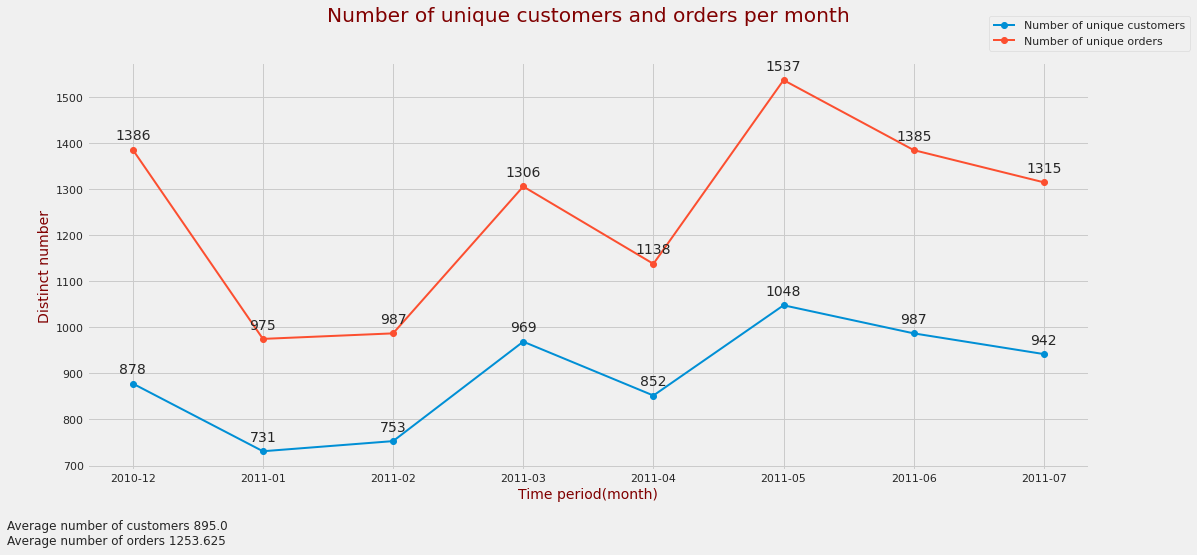

In [61]:
frame=df_cut[['Month_Year', "Customer", 'Invoice']].groupby('Month_Year')['Customer','Invoice'].nunique().reset_index()
x=np.arange(0, len(frame.index), 1)
y=frame.iloc[:,1:].values

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,7))    
obj =plt.plot(x,y, linewidth=2, marker='o' )
plt.xticks(x, frame.iloc[:,0].values, rotation='horizontal')

plt.legend(obj, ('Number of unique customers',  'Number of unique orders'),bbox_to_anchor=(1, 1), loc=8, borderaxespad=1.)
y1=[i[0] for i in y]
for x_,y_ in zip(x,y1):
    plt.annotate(y_, (x_,y_), xytext=(0,10),textcoords="offset points",ha='center')
y2=[i[1] for i in y]
for x_,y_ in zip(x,y2):
    label = "{:.0f}".format(y_)
    plt.annotate(y_, (x_,y_), xytext=(0,10),textcoords="offset points",ha='center')
plt.annotate('Average number of customers {} \nAverage number of orders {}'.format(np.mean(frame.Customer), np.mean(frame.Invoice)), (0,0), (-80,-50), fontsize=12, 
             xycoords='axes fraction', textcoords='offset points', va='top')
plt.xlabel('Time period(month)', fontsize=14, color='maroon') 
plt.ylabel('Distinct number', fontsize=14, color='maroon')
plt.title('Number of unique customers and orders per month', color='maroon', pad=40)
plt.show()

In [86]:
# Number of customers with 50% of sales
cs=df[['Customer', 'Final Price']].groupby('Customer').sum()
cs['ratio']=cs['Final Price'].values/np.sum(cs['Final Price'])*100
cs=cs.sort_values(by=['ratio'], ascending=False)
cs['cum_sum']=cs['ratio'].cumsum()
cs[cs.cum_sum<=50].shape

(173, 3)

In [91]:
# Total number of customers
cs.shape

(3154, 3)

In [90]:
cs.head()

,Final Price,ratio,cum_sum
Customer,,,
MILITEX B.V.,197453.97,4.111281,4.111281
TATA STEEL UK LTD,160334.09,3.338391,7.449672
PowerPak Kereskedelm,89376.40,1.860948,9.310620
UNILEVER ANDINA BOLI,74742.48,1.556248,10.866868
Cefak KG,68798.86,1.432493,12.299362


In [74]:
# Sum of final price - total sales
np.sum(cs['Final Price'])

4802735.46

In [132]:
# how many customers bring 75% of sales?
print(' {} customers bring 50% of total sales, which is {}% from total number of customers in 8 months'.format(cs[cs.cum_sum<=50].shape[0], round(cs[cs.cum_sum<=50].shape[0]/cs.shape[0]*100, 1)))
# how many customers bring 75% of sales?
print(' {} customers bring 75% of total sales, which is {}% from total number of customers in 8 months'.format(cs[cs.cum_sum<=75].shape[0], round(cs[cs.cum_sum<=75].shape[0]/cs.shape[0]*100, 1)))

 173 customers bring 50% of total sales, which is 5.5% from total number of customers in 8 months
 696 customers bring 75% of total sales, which is 22.1% from total number of customers in 8 months


In [108]:
# Number of orders per months
frame['orders_per_customer']=frame.Invoice.values/frame.Customer.values
print(frame.head(8))
print('average orders per customer {} \n'.format(round(np.mean(frame.orders_per_customer),2)))
print('month with the highest number of orders per customer {} \n'.format(frame[frame.orders_per_customer==np.max(frame.orders_per_customer)].Month_Year[0]))

  Month_Year  Customer  Invoice  orders_per_customer
0    2010-12       878     1386             1.578588
1    2011-01       731      975             1.333789
2    2011-02       753      987             1.310757
3    2011-03       969     1306             1.347781
4    2011-04       852     1138             1.335681
5    2011-05      1048     1537             1.466603
6    2011-06       987     1385             1.403242
7    2011-07       942     1315             1.395966
average orders per customer 1.4 

month with the highest number of orders per customer 2010-12 



### Product

In [44]:
#price per unit
f=df[['Sales Product', 'Price per Unit']].groupby('Sales Product').mean()
f.describe()

,Price per Unit
count,3225.000000
mean,2.890149
std,2.916333
min,0.060000
25%,0.850000
50%,1.950000
75%,3.750000
max,16.950000


In [74]:
l=df[['Invoice', 'Sales Product', 'Quantity', 'Final Price']].groupby('Sales Product')['Invoice'].nunique()
l.sort_values( ascending=False).head(2)

Sales Product
OASE WHITE ENRICHED    1297
E A C 70 A 10HPM000    1109
Name: Invoice, dtype: int64

In [75]:
l=df[['Invoice', 'Sales Product', 'Quantity', 'Final Price']].groupby('Sales Product')['Quantity'].sum()
l.sort_values( ascending=False).head(2)

Sales Product
DEMELAN 1990           24466
OASE WHITE ENRICHED    21560
Name: Quantity, dtype: int64

In [76]:
l=df[['Invoice', 'Sales Product', 'Quantity', 'Final Price']].groupby('Sales Product')['Invoice'].nunique()
l=l[l.index.isin(f[f['Price per Unit']>3.75].index)]
l.sort_values( ascending=False).head(2)

Sales Product
E A C 70 A 10HPM000    1109
CUTINA SHINE            978
Name: Invoice, dtype: int64

In [77]:
l=df[['Invoice', 'Sales Product', 'Quantity', 'Final Price']].groupby('Sales Product')['Quantity'].sum()
l=l[l.index.isin(f[f['Price per Unit']>3.75].index)]
l.sort_values( ascending=False).head(2)

Sales Product
CUTINA SHINE           11677
E A C 70 A 10HPM000     8680
Name: Quantity, dtype: int64

In [78]:
l=df[['Invoice', 'Sales Product', 'Quantity', 'Final Price']].groupby('Sales Product')['Invoice'].nunique()
l=l[l.index.isin(f[f['Price per Unit']<0.85].index)]
l.sort_values( ascending=False).head(2)

Sales Product
N,N-DIMETHYLACETAMID    654
ULT.A3HG7 LS BK23189    422
Name: Invoice, dtype: int64

In [79]:
l=df[['Invoice', 'Sales Product', 'Quantity', 'Final Price']].groupby('Sales Product')['Quantity'].sum()
l=l[l.index.isin(f[f['Price per Unit']<0.85].index)]
l.sort_values( ascending=False).head(2)

Sales Product
LUPRANOL 2074           20788
N,N-DIMETHYLACETAMID    20397
Name: Quantity, dtype: int64

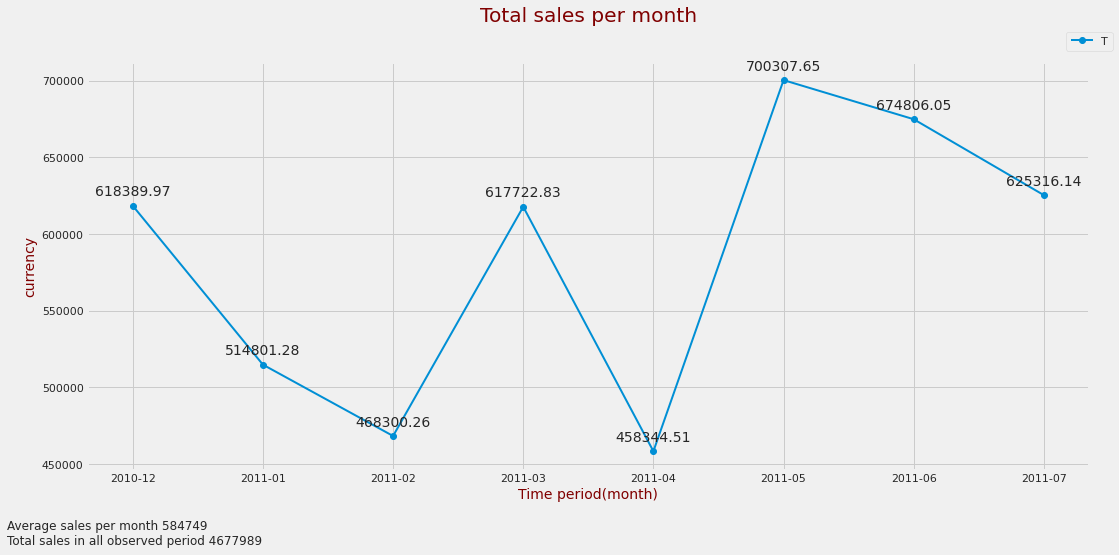

In [89]:
frame=df_cut[['Month_Year', "Final Price"]].groupby('Month_Year')['Final Price'].sum().reset_index()
x=np.arange(0, len(frame.index), 1)
y=frame.iloc[:,1].values

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,7))    
obj =plt.plot(x,y, linewidth=2, marker='o' )
plt.xticks(x, frame.iloc[:,0].values, rotation='horizontal')
plt.legend(obj, ('Time period (months)'),bbox_to_anchor=(1, 1), loc=8, borderaxespad=1.)
for x_,y_ in zip(x,y):
    plt.annotate(y_, (x_,y_), xytext=(0,10),textcoords="offset points",ha='center')
plt.annotate('Average sales per month {} \nTotal sales in all observed period {}'.format(round(np.mean(frame['Final Price'])), round(np.sum(frame['Final Price']))), (0,0), (-80,-50), fontsize=12, 
            xycoords='axes fraction', textcoords='offset points', va='top')
plt.xlabel('Time period(month)', fontsize=14, color='maroon') 
plt.ylabel('currency', fontsize=14, color='maroon')
plt.title('Total sales per month', color='maroon', pad=40)
plt.show()

In [86]:
df_cut[['Month_Year', "Final Price"]].groupby('Month_Year')['Final Price'].sum().sum()

4677988.6899999995